In [1]:
%load_ext autoreload
%autoreload 2

import time
import sys
import importlib
import numpy as np
from prondict import *
from lab2_proto import *
from lab2_tools import *
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 4)
np.set_printoptions(precision=3)
#importlib.import_module(lab2_proto)
#importlib.reload(lab2_proto)
#print("no")
#modules = sys.modules.values()
#print(modules)
#for module in modules:
#    try:
#        imp.reload(module)
#    except:
#        print(module, " could not be reloaded")

In [22]:
#load data
data = np.load('lab2_data.npz', allow_pickle=True)['data']
print(data[0].keys())
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
#phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

dict_keys(['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc'])


In [3]:
# isolate the prondict 

isolated = {}
for pron in prondict.keys():
    isolated[pron] = ['sil']+prondict[pron]+['sil']
    

# concatenation HMM

In [4]:
hmm1 = phoneHMMs['f']
hmm2 = phoneHMMs['sp']
print(hmm1['transmat'])
print()
print(hmm2['transmat'])
print()
print()
print(hmm1['startprob'])
print(hmm2['startprob'])
print("\n==========================================================")
print("==========================================================\n")
twoHMms=concatTwoHMMs(hmm1, hmm2)
print(twoHMms['startprob'])
print()
print(twoHMms['transmat'])

[[0.844 0.156 0.    0.   ]
 [0.    0.709 0.291 0.   ]
 [0.    0.    0.306 0.694]
 [0.    0.    0.    1.   ]]

[[0.814 0.186]
 [0.    1.   ]]


[1. 0. 0. 0.]
[0.24 0.76]


[1. 0. 0. 0. 0.]

[[0.844 0.156 0.    0.    0.   ]
 [0.    0.709 0.291 0.    0.   ]
 [0.    0.    0.306 0.167 0.527]
 [0.    0.    0.    0.814 0.186]
 [0.    0.    0.    0.    1.   ]]


In [5]:
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs, isolated['o'])

print(wordHMMs['o']['transmat'])

print(wordHMMs['o']['means'].shape)
print(wordHMMs['o']['covars'].shape)



[[0.838 0.162 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.912 0.088 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.789 0.211 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.809 0.191 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.89  0.11  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.862 0.138 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.838 0.162 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.912 0.088 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.789 0.211]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]
(9, 13)
(9, 13)


## create all the HMMs

In [6]:
for key in isolated.keys():
    wordHMMs[key] = concatHMMs(phoneHMMs, isolated[key])


## load the example

In [7]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())


['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

# HMMs

## Gaussian Emission

(9, 13)  

  (9, 13)
/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/woman/ew/oa.wav
True


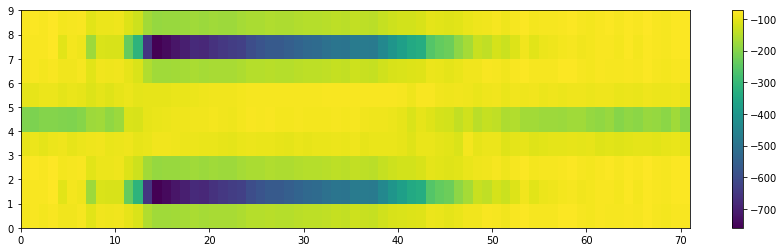

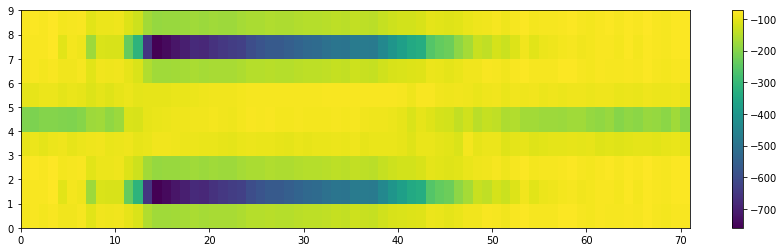

In [8]:
logProb = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])

#print(wordHMMs['o']['means']," \n\n ", wordHMMs['o']['covars'])
print(wordHMMs['o']['means'].shape," \n\n ", wordHMMs['o']['covars'].shape)
print(example['filename'])

print(np.allclose(logProb, example['obsloglik']))

plt.pcolormesh(logProb.T)
plt.colorbar()
plt.show()
plt.pcolormesh(example['obsloglik'].T)
plt.colorbar()
plt.show()

What can you say about the figure?
We have a low likelyhood of beeing in state 6 and 1 for most of the time. In the beegining and the endthe probability of beeing in state 4 is low.
The model consists of 9 states, the first and last 3 belong to the silence.
Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence?
In the middle part we have the highest probability of being in sate 3-6, but the other ones are lower. 
State 1 and 7 probably resemble silence, since it is low in the middle. the states 4,5,6 resemble the word, since it has high likelihood in the middle

## alpha pass

True


/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


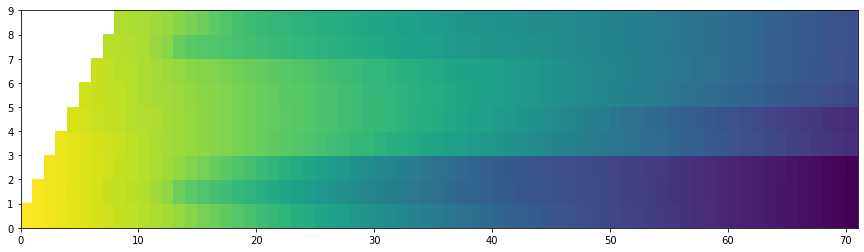

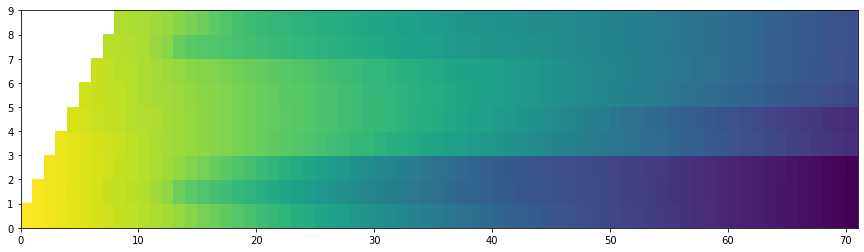

In [23]:
alphas = forward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))

#print(alphas)
print(np.allclose(alphas, example['logalpha']))

plt.pcolormesh(alphas.T)
plt.show()
plt.pcolormesh(example['logalpha'].T)
#print(example['logalpha'][0])
plt.show()

$\alpha_t(j) = P(O_{1:t}, X_t = j | \lambda)$ and we want to get $P(O_{1:T} | \lambda$ marganilisinning over all the states gives us $ \sum_{j=0}^M P(O_{1:T}, X = j | \lambda)$ plugging in alpha is equal to $\sum_{j=0}^M \alpha_T(j)$, which is the likelihood of observing the sequence. 

We are working in log domain to avoid underflows. This means multiplications are additions. This is why the alpha formula is having a sum of additions instead of a sum of multiplications. Since the alphas are in log domain, we need to transform them back to linear domain, apply the sum and then we can transform them back to log domain. Hence logsumexp().

# rate the samples

In [10]:

a = time.process_time() 
for sample in data:
    bestLikelihood = float("-inf")
    bestHmm = None
    for hmmName in wordHMMs.keys():
        #print(hmmName)
        obslik = log_multivariate_normal_density_diag(sample['lmfcc'], wordHMMs[hmmName]['means'], wordHMMs[hmmName]['covars'])
        
        alpha = forward(obslik, np.log(wordHMMs[hmmName]['startprob']), np.log(wordHMMs[hmmName]['transmat']))
        
        prob = logsumexp(alpha[-1])
        if prob > bestLikelihood:
            bestHmm = hmmName
            bestLikelihood = prob
            
    print("best fit for", sample['filename'][-15:], " is ", bestHmm)
b = time.process_time() 
print("time elabsed: ",b-a)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


best fit for t/man/bm/oa.wav  is  o
best fit for t/man/bm/ob.wav  is  o
best fit for t/man/bm/za.wav  is  z
best fit for t/man/bm/zb.wav  is  z
best fit for t/man/bm/1a.wav  is  3
best fit for t/man/bm/1b.wav  is  9
best fit for t/man/bm/2a.wav  is  3
best fit for t/man/bm/2b.wav  is  2
best fit for t/man/bm/3a.wav  is  3
best fit for t/man/bm/3b.wav  is  3
best fit for t/man/bm/4a.wav  is  4
best fit for t/man/bm/4b.wav  is  4
best fit for t/man/bm/5a.wav  is  3
best fit for t/man/bm/5b.wav  is  3
best fit for t/man/bm/6a.wav  is  6
best fit for t/man/bm/6b.wav  is  6
best fit for t/man/bm/7a.wav  is  3
best fit for t/man/bm/7b.wav  is  3
best fit for t/man/bm/8a.wav  is  3
best fit for t/man/bm/8b.wav  is  3
best fit for t/man/bm/9a.wav  is  9
best fit for t/man/bm/9b.wav  is  z
best fit for woman/ew/oa.wav  is  o
best fit for woman/ew/ob.wav  is  o
best fit for woman/ew/za.wav  is  z
best fit for woman/ew/zb.wav  is  z
best fit for woman/ew/1a.wav  is  1
best fit for woman/ew/1b.wav

It performs good detecting the woman leading to 100% correct detection, but the man is not as good. 
The might have been trained on a female speaker. Therefore the male detection is not as good, the 0, 3, 4, 6 and zero get detected well, but we have many false positive for 3. 5,7,8 get not detected and classified as 3 instead. 

### all data traines hmm
The HMM trained with all data performed much better with just 1 false classification.


# betapass

True


/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


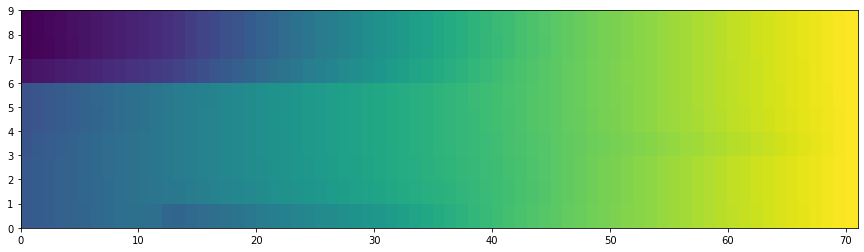

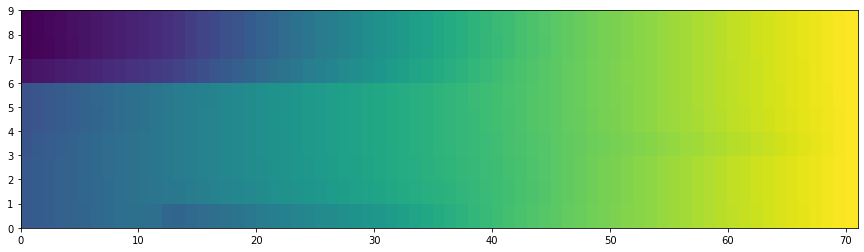

In [24]:
betas = backward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))

#print(alphas)
print(np.allclose(betas, example['logbeta']))

plt.pcolormesh(betas.T)
plt.show()
plt.pcolormesh(example['logbeta'].T)
#print(example['logbeta'][0])
plt.show()

The overall probability can be computed by:
$\sum_{i=0}^M \Phi_1(X_1)*\beta_1(i)$

# Viterbi

True True
-5974.211288357338


/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


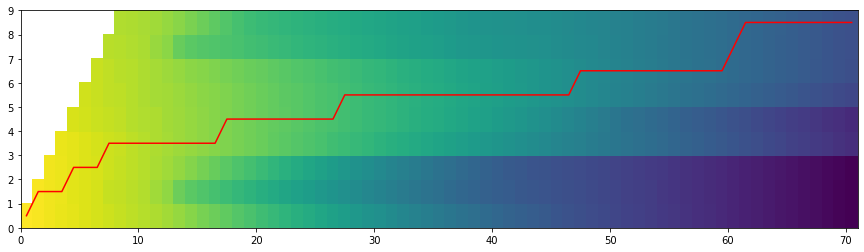

In [12]:
prob, path = viterbi(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))
path = np.array(path)
print(np.allclose(path, example['vpath']), np.allclose(prob, example['vloglik']))
print(prob)

plt.pcolormesh(alphas.T)
plt.plot(np.arange(0.5, path.shape[0], 1), path+0.5, 'r')
plt.show()


The viterbi gives the sequence through the states, which is the most likely given the observation and parameters. In the plot we can see that the path moves throught the areas, which have a higher probability (alpha pass). You could say that the path tries to stay in areas with higher probability. In our case that is exactly where the path moves through.

# scoring viterbi

In [13]:
a = time.process_time()
for sample in data:
    bestLikelihood = float("-inf")
    bestHmm = None
    for hmmName in wordHMMs.keys():
        #print(hmmName)
        obslik = log_multivariate_normal_density_diag(sample['lmfcc'], wordHMMs[hmmName]['means'], wordHMMs[hmmName]['covars'])
        
        prob, path = viterbi(obslik, np.log(wordHMMs[hmmName]['startprob']), np.log(wordHMMs[hmmName]['transmat']))
        
        
        if prob > bestLikelihood:
            bestHmm = hmmName
            bestLikelihood = prob
            
    print("best fit for", sample['filename'][-15:], " is ", bestHmm)
    
b = time.process_time() 
print("time elabsed: ",b-a)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


best fit for t/man/bm/oa.wav  is  o
best fit for t/man/bm/ob.wav  is  o
best fit for t/man/bm/za.wav  is  z
best fit for t/man/bm/zb.wav  is  z
best fit for t/man/bm/1a.wav  is  3
best fit for t/man/bm/1b.wav  is  9
best fit for t/man/bm/2a.wav  is  3
best fit for t/man/bm/2b.wav  is  2
best fit for t/man/bm/3a.wav  is  3
best fit for t/man/bm/3b.wav  is  3
best fit for t/man/bm/4a.wav  is  4
best fit for t/man/bm/4b.wav  is  4
best fit for t/man/bm/5a.wav  is  3
best fit for t/man/bm/5b.wav  is  3
best fit for t/man/bm/6a.wav  is  6
best fit for t/man/bm/6b.wav  is  6
best fit for t/man/bm/7a.wav  is  3
best fit for t/man/bm/7b.wav  is  3
best fit for t/man/bm/8a.wav  is  3
best fit for t/man/bm/8b.wav  is  3
best fit for t/man/bm/9a.wav  is  9
best fit for t/man/bm/9b.wav  is  z
best fit for woman/ew/oa.wav  is  o
best fit for woman/ew/ob.wav  is  o
best fit for woman/ew/za.wav  is  z
best fit for woman/ew/zb.wav  is  z
best fit for woman/ew/1a.wav  is  1
best fit for woman/ew/1b.wav

### all speakers HMM
The algoritm performs with 0 missclassification, slightly better than alphapass
### one speaker trained
again we have no errors for female pronaunciation. The other errors are also similar. 0,3,4,6 get classified correctly, but 5,7,8 not. 
### complexity 
viterbi runs faster than alphaspass. Time complexity should be the same, but it does not need to compute several sums each iteration.

## gammas

True
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


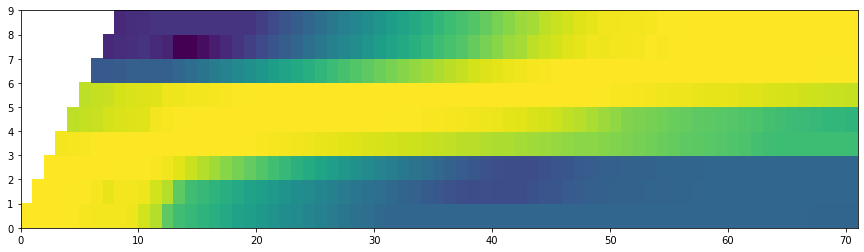

[ 1.346  2.096  3.558  9.738 10.12  20.533 12.997  1.209  9.404]
71.00000000002396


In [29]:
gammas = statePosteriors(alphas, betas)
#gammas = statePosteriors(example['logalpha'],example['logbeta'])

print(np.allclose(gammas, example['loggamma']))
sumGamma = np.sum(np.exp(gammas), axis = 1)
print(sumGamma)
plt.pcolormesh(gammas.T)
plt.show()

sumAlongTime = np.sum(np.exp(gammas), axis = 0)
print(sumAlongTime)
print(sumAlongTime.sum())

the sum tells us the how long(including the probaility) one has been in the state. 
The sum of this vecotor gives us the total length of the sequence.


the $\gamma_t(i) = p(z_t = i | \theta, X)$ describes the posterior of beeing in state i at time t given, the model and the observations. The GMM output model does not consider that. The Gaussian posterior does not account for the model or the whole timesequence it only considers the current features: $\gamma_t^{GMM} = P(z_t = i | x_t, means, vars)$. 

The posterior $\gamma_t^{GMM} = P(z_t = i | x_t, means, vars) = \frac{P(x_t | z_n=i) * P (z_n=i)}{P(x_n)}$
assuming equal prioris we can dicard them

(71, 9)
(71,)


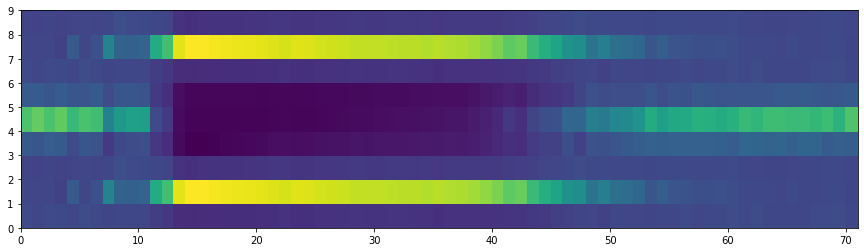

In [38]:
posterior = example['obsloglik']
evidence = np.sum(example['obsloglik'], axis=1)
print(posterior.shape)
print(evidence.shape)
posterior = posterior / evidence[np.newaxis].T

plt.pcolormesh(posterior.T)
plt.show()

# Expectation Maximisation

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


inital prob:  -7266.031813096327


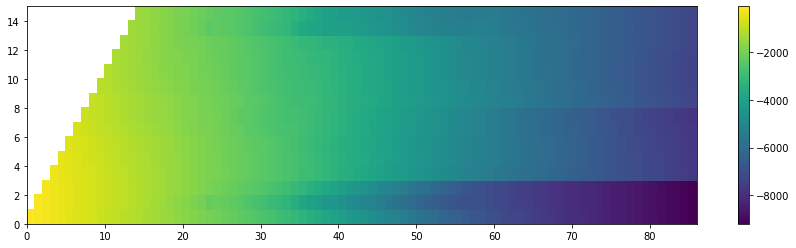

-7266.031813096327
-7266.031813096327


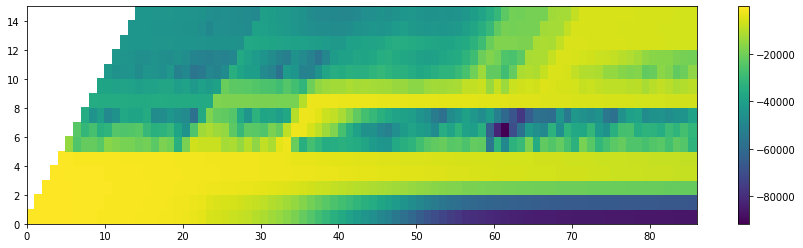

-6316.420997654044
-6316.420997654044


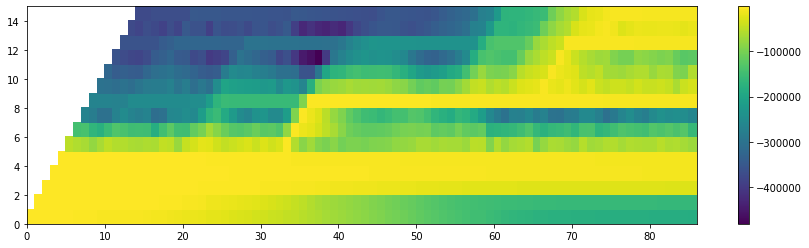

-6154.093763744948
-6154.093763744948


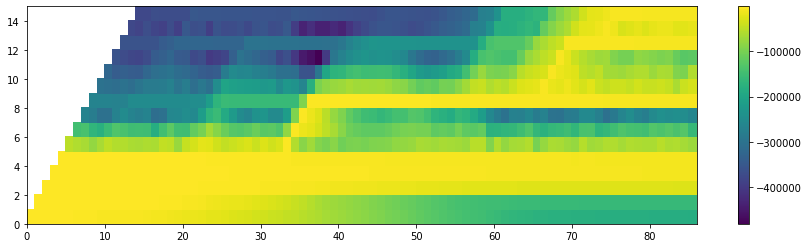

-6151.934110268132
-6151.934110268132


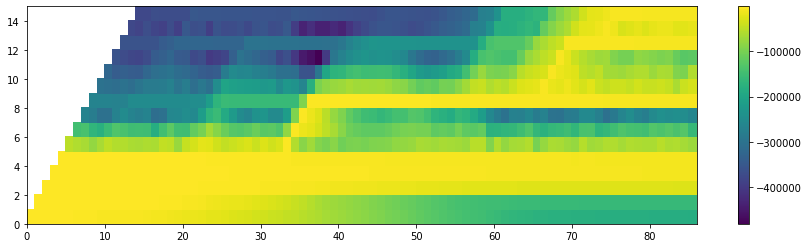

-6151.934110176128
-6151.934110176128


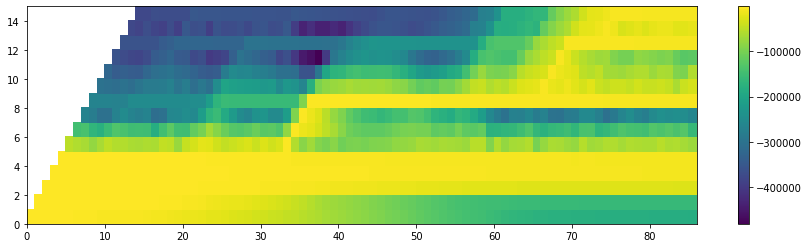

-6151.934110176125
-6151.934110176125


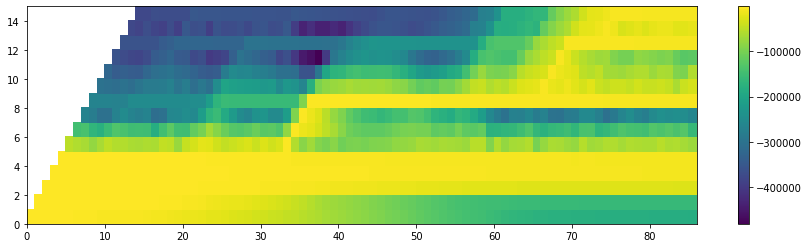

-6151.934110176128
-6151.934110176128


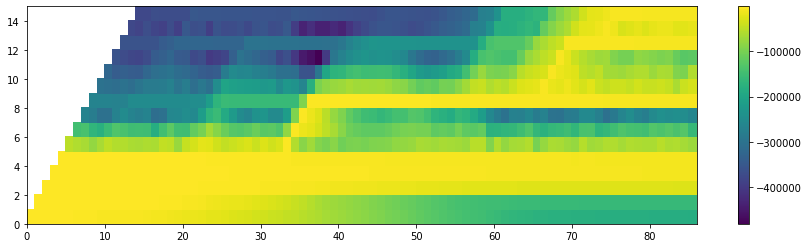

-6151.9341101761265
-6151.9341101761265


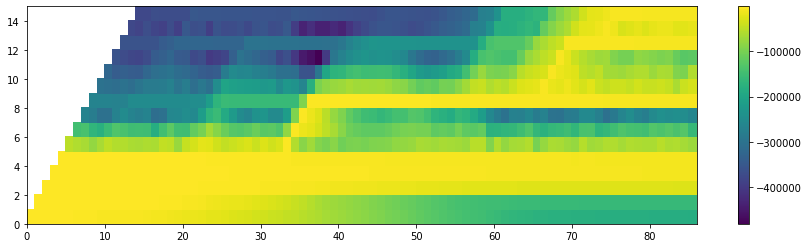

-6151.934110176129
-6151.934110176129


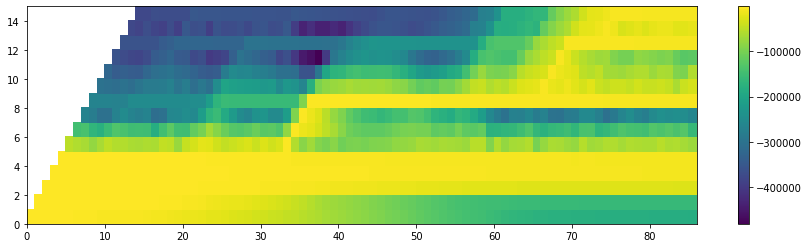

-6151.934110176127
-6151.934110176127


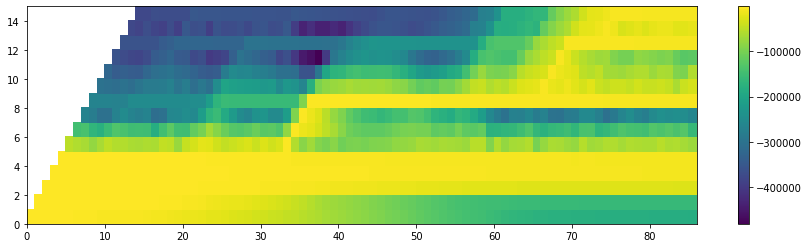

-6151.934110176128
-6151.934110176128


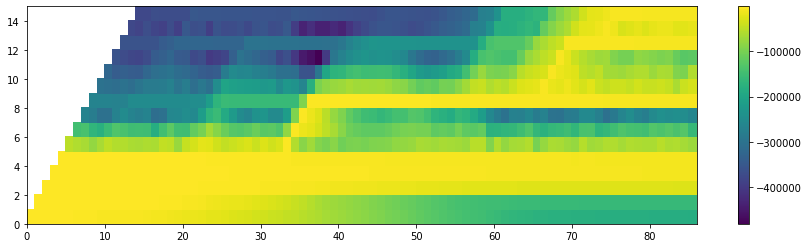

-6151.934110176125
-6151.934110176125


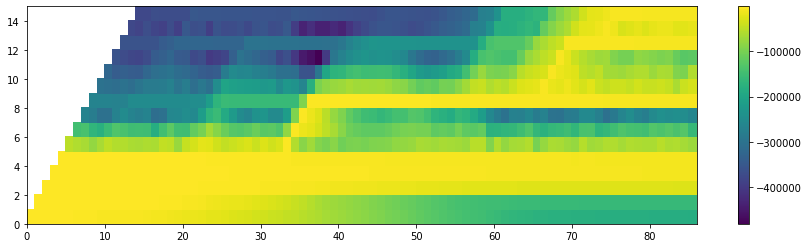

-6151.934110176128
-6151.934110176128


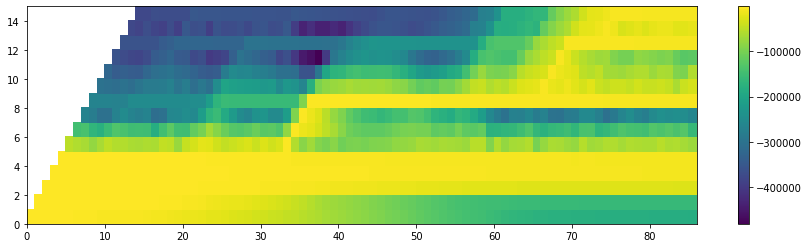

-6151.934110176124
-6151.934110176124


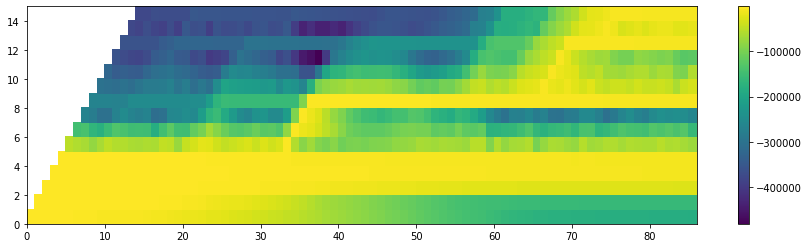

-6151.9341101761265
-6151.9341101761265


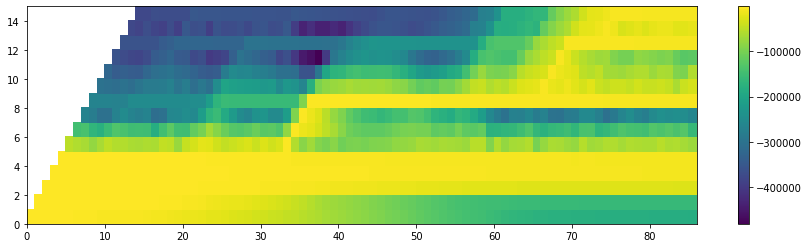

-6151.934110176126
-6151.934110176126


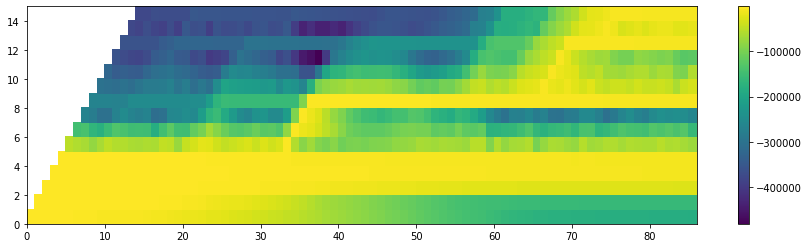

-6151.934110176127
-6151.934110176127


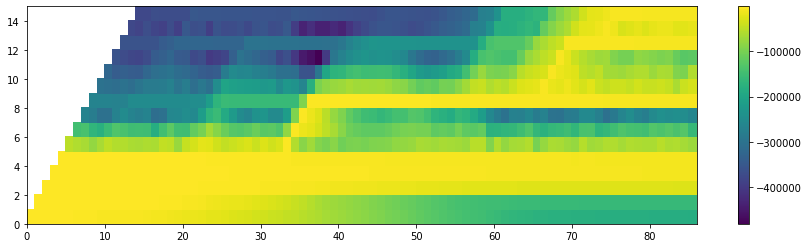

-6151.934110176127
-6151.934110176127


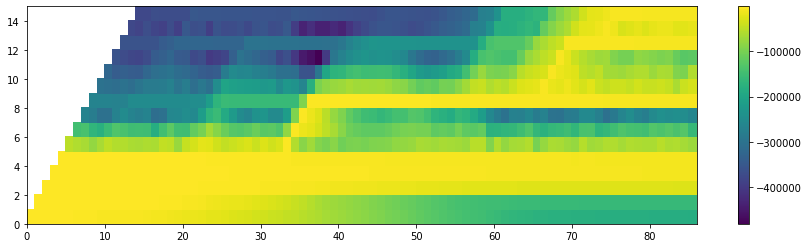

-6151.934110176126
-6151.934110176126


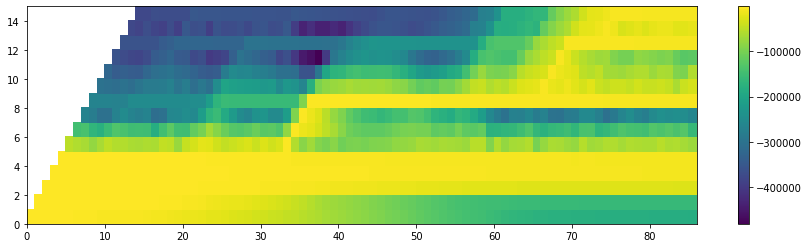

-6151.934110176126
-6151.934110176126


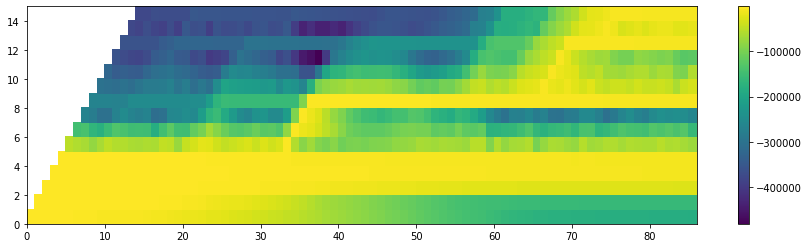

-6151.934110176127
-6151.934110176127
converged after:  21  iterations.


In [31]:
model = wordHMMs['3']
datum = data[10]

features = datum['lmfcc']

obsLogLik =  log_multivariate_normal_density_diag(features, model['means'], model['covars'])

alphas = forward(obsLogLik, np.log(model['startprob']), np.log(model['transmat']))
#betas = backward(obsLogLik, np.log(model['startprob']), np.log(model['transmat']))
#gammas = statePosteriors(alphas, betas)
print("inital prob: ", logsumexp(alphas[-1]))
means = model['means']
covars = model['covars']
#print(means)
#print(covars)
#print("\n\n\n")
oldprob = float("-inf")
converged = False
count = 0
while not converged:
    count +=1
    obsLogLik =  log_multivariate_normal_density_diag(features, means, covars)
    
    alphas = forward(obsLogLik, np.log(model['startprob']), np.log(model['transmat']))
    betas = backward(obsLogLik, np.log(model['startprob']), np.log(model['transmat']))
    gammas = statePosteriors(alphas, betas)
    plt.pcolormesh(alphas.T)
    plt.colorbar()
    plt.show()
    #update means and vars
    means, covars = updateMeanAndVar(features, gammas)
    #print(means)
    #print(covars)
    #print(alphas[0,0])
    print(logsumexp(alphas[-1]))
    #print(np.exp(alphas[-1]))
    prob = logsumexp(alphas[-1])
    print(prob)
    if(prob<oldprob) or count > 20:
        print("converged after: ",count," iterations.")
        converged = True
    oldProb = prob

With data[10] and HMM model 4 we get an inital loglikelihood of -7227 and a final of -5963.15
if we use word model[3] initally the log likelyhood is-7266 ad the final one -6151.9